In [2]:
import os
import json
import gzip
import pickle
import numpy as np
import glob

import pandas as pd
from urllib.request import urlopen
import matplotlib.pyplot as plt
from datetime import datetime
from collections import defaultdict
from tqdm import tqdm

import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

#nltk.download()
#nltk.download('stopwords')
#nltk.download('punkt')


#import more_itertools as mit
#from keras.preprocessing.sequence import pad_sequences


import torch
#from pytorch_pretrained_bert import BertTokenizer, BertModel
from transformers import BertTokenizer, BertModel, BertForSequenceClassification
from torch.utils.data import DataLoader, Dataset

In [3]:
bert_loaded = False

In [4]:
%%time

if not bert_loaded:
    bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    bert_tokenizer.add_special_tokens({"unk_token": '[UNK]', 'cls_token': '[CLS]', 
                                       'pad_token':'[PAD]', 'sep_token':'[SEP]'})
    print(len(bert_tokenizer))
    assert bert_tokenizer.cls_token == '[CLS]'
    bert_tokenizer.sep_token_id
    
    bert_model = BertModel.from_pretrained('bert-base-uncased', output_hidden_states=True,
                                            output_attentions=True)
    bert_model.resize_token_embeddings(len(bert_tokenizer))
    
    bert_loaded = True

30522
CPU times: user 2.16 s, sys: 500 ms, total: 2.66 s
Wall time: 9.7 s


In [5]:
def parse(path, chunk_size=20000):
    i = 0
    with gzip.open(path, 'rb') as f:
        for l in f:
            yield json.loads(l.strip())
            i+=1
            if i == chunk_size:
                break
def parse2(f):
    for l in f:
        yield json.loads(l.strip())        
            
def getDF(path, chunk_size):
    i = 0
    df = {}
    for d in parse(path, chunk_size):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

def getDF_chunks(path, chunk_size, pkl_path, max_chunks=4):
    i = 0
    df = {}
    df_chunks = 0
    with gzip.open(path, 'rb') as f:
        for d in parse2(f):
            df[i] = d
            i+=1
            
            if i == chunk_size:
                df = pd.DataFrame.from_dict(df, orient='index')
                #preprocessing(df)
                df.to_pickle(pkl_path + "df" + str(df_chunks) +".pkl")
                df = {}
                i = 0
                df_chunks +=1
    return df_chunks, i

In [6]:
'''
!wget http://deepyeti.ucsd.edu/jianmo/amazon/sample/meta_Computers.json.gz
df = getDF('meta_Computers.json.gz')
len(df)
### remove rows with unformatted title (i.e. some 'title' may still contain html style content)

df3 = df.fillna('')
df4 = df3[df3.title.str.contains('getTime')] # unformatted rows
df5 = df3[~df3.title.str.contains('getTime')] # filter those unformatted rows
print("Unformatted rows: {} ({:.2f}%)".format(len(df4), len(df4)/len(df3)*100))
print("Remaining rows: {}".format(len(df5)))

'''

'\n!wget http://deepyeti.ucsd.edu/jianmo/amazon/sample/meta_Computers.json.gz\ndf = getDF(\'meta_Computers.json.gz\')\nlen(df)\n### remove rows with unformatted title (i.e. some \'title\' may still contain html style content)\n\ndf3 = df.fillna(\'\')\ndf4 = df3[df3.title.str.contains(\'getTime\')] # unformatted rows\ndf5 = df3[~df3.title.str.contains(\'getTime\')] # filter those unformatted rows\nprint("Unformatted rows: {} ({:.2f}%)".format(len(df4), len(df4)/len(df3)*100))\nprint("Remaining rows: {}".format(len(df5)))\n\n'

In [7]:
os.listdir('../datasets')

['meta_Computers.json.gz',
 'Electronics_5.json.gz',
 'Books_5.json.gz',
 'one_week.tar.gz',
 'contentdata.tar.gz',
 'books-pickle']

In [56]:
def clean_text2(sent, remove_stop_word=False, stemming=False, stemmer=None):
    stop_words = list(set(stopwords.words('english')))
    #tokenise, punctuation, lower-case
    tokens = [word.lower() for sent in sent_tokenize(sent) for word in word_tokenize(sent) if word.isalpha()]
    
    if remove_stop_word:
        #filter stop words
        tokens = [word for word in tokens if word not in stop_words]
    
    if stemming:
        tokens = [stemmer.stem(token) for token in tokens]
        
    #locating and correcting common typos & misspellings
        
    return " ".join(tokens)

def clean_text(sent, tokenizer, stop_words=None, stemmer=None):

    # tokenise & punctuation
    tokens = [word for word in tokenizer.tokenize(sent) if word.isalpha()]

    if not stop_words == None:
        #stop_words = list(set(stopwords.words('english')))
        # filter stop words
        tokens = [word for word in tokens if word not in stop_words]

    if not stemmer == None:
        tokens = [stemmer.stem(token) for token in tokens]

    # locating and correcting common typos & misspellings

    return tokens


def clean_df(df, drop_org_reviews=False):
    ### remove rows with unformatted title (i.e. some 'title' may still contain html style content)

    df = df.fillna('')
    df = df.drop(['reviewerName', 'style', 'vote', 'image'], axis=1)
    
    #reformat timestamp
    df['reviewTime'] = df['unixReviewTime'].apply(lambda x: pd.Timestamp(x, unit='s'))
    df = df.drop('unixReviewTime', axis=1)
    
    #rename columns
    df = df.rename(columns={'asin':'itemID'})
    
    #aggregate text
    df['reviewText'] = df['summary'] + " " + df['reviewText']
    df = df.drop('summary', axis=1)
    
    ## convert to other (smaller) datatype
    df['overall'] = df['overall'].astype('int32')
    
    #clean text
    if 'cleanedText' not in df.columns:
        print("Cleaning Text..")
        df['reviewWords'] = df['reviewText'].apply(lambda x: len(clean_text(x, bert_tokenizer)))
        if drop_org_reviews:
            df = df.drop('reviewText', axis=1)
        
    return df

def aggregate_info(df, user_d, items_d):
    
    added = 0
    updated = 0
    
    print("Aggregating User Stats..")
    for u, group in tqdm(df.groupby('reviewerID')):
        
        if u not in user_d:
            user_d[u] = {}
            user_d[u]['n_reviews'] = group['itemID'].count()
            user_d[u]['m_rating'] = group['overall'].mean()
            user_d[u]['m_words'] = group['reviewWords'].mean()
            added+=1
        else:
            user_d[u]['n_reviews'] += group['itemID'].count()
            user_d[u]['m_rating'] = np.mean([user_d[u]['m_rating'], group['overall'].mean()])
            user_d[u]['m_words'] = np.mean([user_d[u]['m_words'], group['reviewWords'].mean()])
            updated+=1

    print("Total users: %.0f" % len(user_d.keys()))
    print("Added: %.0f" % added)
    print("Updated: %.0f" % updated)
     
                
    #count reviews per item
    added = 0
    updated = 0
    
    print("Aggregating Item Stats..")
    for item, group in tqdm(df.groupby('itemID')):
    
        if item not in items_d:
            items_d[item] = {}
            items_d[item]['n_reviews'] = group['reviewerID'].count()
            items_d[item]['m_rating'] = group['overall'].mean()
            items_d[item]['m_words'] = group['reviewWords'].mean()
            added+=1
        else:
            items_d[item]['n_reviews'] += group['reviewerID'].count()
            items_d[item]['m_rating'] = np.mean([items_d[item]['m_rating'], group['overall'].mean()])
            items_d[item]['m_words'] = np.mean([items_d[item]['m_words'], group['reviewWords'].mean()])
            updated+=1
    
    print("Total items: %.0f" % len(items_d.keys()))
    print("Added: %.0f" % added)
    print("Updated: %.0f" % updated)  
    
    return user_d, items_d


def preprocessDF_chunks(path, chunk_size, pkl_path, drop_org_reviews=False, max_chunks=4):
    i = 0
    data = {}
    n_chunks = 0
    
    #aggreated info
    user_dict = {}
    item_dict = {}
    
    with gzip.open(path, 'rb') as f:
        print("Start reading: {}".format(path))
        for d in parse2(f):
            data[i] = d
            i+=1
            
            #if i == 10:
            #    print(d)
            
            if i == chunk_size:
                print("Processing Chunk {}".format(n_chunks))
                
                #print(list(data.items())[:2])
                
                df = pd.DataFrame.from_dict(data, orient='index')
                #preprocessing
                df = clean_df(df, drop_org_reviews)
                
                #aggregate info
                user_dict, item_dict = aggregate_info(df, user_dict, item_dict)
                
                #save cleaned dataframe
                df.to_pickle(pkl_path + "df" + str(n_chunks) +".pkl")
                
                #save stats
                with open(pkl_path + "user_stats.pkl", 'wb') as fout:
                    pickle.dump(user_dict, fout)
                with open(pkl_path + "item_stats.pkl", 'wb') as fout:
                    pickle.dump(item_dict, fout)
                
                i = 0
                data = {}
                n_chunks +=1
                print("\n")
                
            if max_chunks < n_chunks:
                break
                
    return n_chunks, i, user_dict, item_dict

In [57]:
(dirpath, dirnames, filenames) = next(os.walk('../datasets/books-pickle/'), (None, None, []))
filenames

['df2.pkl',
 'item_stats.pkl',
 'df3.pkl',
 'df0.pkl',
 'df1.pkl',
 'user_stats.pkl',
 'df.pkl',
 'encoded_text.pkl']

In [58]:
books_path = '../datasets/Books_5.json.gz'
chunk_size=20000
pkl_path = '../datasets/books-pickle/'

user_dict = {}
item_dict = {}

dev=False

if dev:
    df = getDF(books_path, chunk_size=10000)
    df = clean_df(df)
    user_dict, item_dict = aggregate_info(df, user_dict, item_dict)
else:
    n_chunks, i, user_dict, item_dict = preprocessDF_chunks(books_path, chunk_size, pkl_path, drop_org_reviews=True, max_chunks=5)
    df = pickle.load(pkl_path + "df1.pkl")
    
print("###############")
print(len(df))

Start reading: ../datasets/Books_5.json.gz
Processing Chunk 0
Cleaning Text..
Aggregating User Stats..


100%|██████████| 160/160 [00:00<00:00, 1167.40it/s]


Total users: 17720
Added: 17720
Updated: 0
Aggregating Item Stats..
Total items: 160
Added: 160
Updated: 0


Processing Chunk 1
Cleaning Text..
Aggregating User Stats..


100%|██████████| 122/122 [00:00<00:00, 1310.53it/s]


Total users: 31920
Added: 14200
Updated: 2618
Aggregating Item Stats..
Total items: 278
Added: 118
Updated: 4


Processing Chunk 2
Cleaning Text..
Aggregating User Stats..


100%|██████████| 144/144 [00:00<00:00, 1467.33it/s]


Total users: 47970
Added: 16050
Updated: 2287
Aggregating Item Stats..
Total items: 421
Added: 143
Updated: 1


Processing Chunk 3
Cleaning Text..
Aggregating User Stats..


100%|██████████| 240/240 [00:00<00:00, 1410.71it/s]


Total users: 61018
Added: 13048
Updated: 4491
Aggregating Item Stats..
Total items: 659
Added: 238
Updated: 2


Processing Chunk 4
Cleaning Text..
Aggregating User Stats..


100%|██████████| 172/172 [00:00<00:00, 1393.17it/s]


Total users: 76043
Added: 15025
Updated: 3313
Aggregating Item Stats..
Total items: 829
Added: 170
Updated: 2


Processing Chunk 5
Cleaning Text..
Aggregating User Stats..


100%|██████████| 107/107 [00:00<00:00, 1385.14it/s]


Total users: 91048
Added: 15005
Updated: 2898
Aggregating Item Stats..
Total items: 934
Added: 105
Updated: 2




TypeError: file must have 'read' and 'readline' attributes

In [18]:
len(user_dict.keys())

8908

## User

In [21]:
print("Number of unique reviewers: {}".format(df['reviewerID'].nunique()))

Number of unique reviewers: 8908


In [42]:
user_dict = {}

In [58]:
%%time
u_users = list(df['reviewerID'].unique())
for u in tqdm(u_users):
    n_re = df[df["reviewerID"] == u]["itemID"].count()
    if u not in user_dict:
        user_dict[u] = {}
        user_dict[u]['n_reviews'] = n_re
    else:
        user_dict[u]['n_reviews'] += n_re

100%|██████████| 8908/8908 [00:22<00:00, 396.97it/s]

CPU times: user 22.3 s, sys: 128 ms, total: 22.4 s
Wall time: 22.4 s


In [26]:
df[df["reviewerID"] == 'A1SDAYRVRR62ZH']['itemID'].count()

1

In [27]:
#plt.hist(user_dict.values()['n_reviews'], bins=[1,2,4,6,10])

## Items

In [29]:
#for name, val in df.groupby("itemID")['reviewerID']:
    #print(name + " " + str(val.count()))

In [30]:
df.groupby("itemID")['reviewerID'].count().sort_values(ascending=False).head(10)

itemID
0001844423    2753
0002005549     778
0001720392     774
0001951076     681
0002051850     603
0001945424     556
0001384198     451
0001381733     317
0002180618     302
0002008599     210
Name: reviewerID, dtype: int64

Text(0.5, 1.0, 'Reviews per Item')

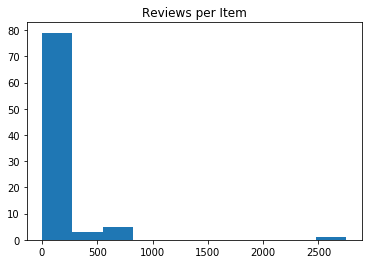

In [31]:
plt.hist(df.groupby("itemID")['reviewerID'].count())
plt.title("Reviews per Item")
#plt.xaxis("# Reviews")

Mean: 4.50
Median: 5.0


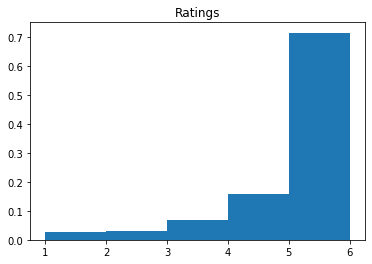

In [32]:
hist = plt.hist(df['overall'], bins=[1,2,3,4,5,6], density=True)
plt.title('Ratings')
print("Mean: %.2f" % df['overall'].mean())
print("Median: %.1f" % df['overall'].median())

## Content

In [33]:
# tokenise content

In [11]:
row = 10 

sent = df['reviewText'].iloc[row]

print(len(sent))
print(sent)

477
Maybe It's Not As Bad As You Think So, you think you have problems? Things could be worse and this clever book can prove it. The king starts out with a problem. The mice are eating his cheese. The more he tries to fix the problem, the worse it gets. The king finally arranges to bring back the mice when he comes to the realization that his original dilemma  wasn't so intolerable after all. The solution requires cooperation from the king and the mice. It involves the cheese.


In [12]:
stop_words = list(set(stopwords.words('english')))
sent_tokenize(sent)

["Maybe It's Not As Bad As You Think So, you think you have problems?",
 'Things could be worse and this clever book can prove it.',
 'The king starts out with a problem.',
 'The mice are eating his cheese.',
 'The more he tries to fix the problem, the worse it gets.',
 "The king finally arranges to bring back the mice when he comes to the realization that his original dilemma  wasn't so intolerable after all.",
 'The solution requires cooperation from the king and the mice.',
 'It involves the cheese.']

In [19]:
tokens = [word for word in bert_tokenizer.tokenize(sent) if word.isalpha()]
print(len(tokens))

90


In [20]:
#tokenise, punctuation, lower-case
tokens = [word.lower() for sent in sent_tokenize(sent) for word in word_tokenize(sent) if word.isalpha()]

#filter stop words
#tokens = [word for word in tokens if word not in stop_words]

print(len(tokens))

88


In [37]:
#stemming?
stemmer = PorterStemmer()
stemmed = [stemmer.stem(token) for token in tokens]
" ".join(stemmed)

'mayb it not as bad as you think so you think you have problem thing could be wors and thi clever book can prove it the king start out with a problem the mice are eat hi chees the more he tri to fix the problem the wors it get the king final arrang to bring back the mice when he come to the realiz that hi origin dilemma wa so intoler after all the solut requir cooper from the king and the mice it involv the chees'

In [106]:
review_length = df['reviewText'].apply(lambda x: len(x))
df[df['reviewText'].apply(lambda x: len(x)) < 10].count()

#plt.hist(review_length)

overall        5
verified       5
reviewTime     5
reviewerID     5
itemID         5
reviewText     5
cleanedText    5
reviewWords    5
dtype: int64

In [12]:
def clean_text_bert(text, tokenizer):
    return tokenizer.tokenize(text)

In [26]:
sent = "Let's see how text is handled if there're errors!!"
print(clean_text_bert(sent, bert_tokenizer))
print(bert_tokenizer.convert_tokens_to_ids(clean_text_bert(sent, bert_tokenizer)))

sent = "Let's see how txet is hanled if there're errors!!"
print(clean_text_bert(sent, bert_tokenizer))
print(bert_tokenizer.convert_tokens_to_ids(clean_text_bert(sent, bert_tokenizer)))

print(bert_tokenizer.encode(sent, max_length=30, add_special_tokens=True, pad_to_max_length=True))

['let', "'", 's', 'see', 'how', 'text', 'is', 'handled', 'if', 'there', "'", 're', 'errors', '!', '!']
[2292, 1005, 1055, 2156, 2129, 3793, 2003, 8971, 2065, 2045, 1005, 2128, 10697, 999, 999]
['let', "'", 's', 'see', 'how', 'tx', '##et', 'is', 'han', '##led', 'if', 'there', "'", 're', 'errors', '!', '!']
[2292, 1005, 1055, 2156, 2129, 19067, 3388, 2003, 7658, 3709, 2065, 2045, 1005, 2128, 10697, 999, 999]
[101, 2292, 1005, 1055, 2156, 2129, 19067, 3388, 2003, 7658, 3709, 2065, 2045, 1005, 2128, 10697, 999, 999, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [13]:
%%time

use_both=False
use_bert=True

if use_both:
    df['cleanedTextBert'] = df['reviewText'].apply(lambda x: clean_text_bert(x, bert_tokenizer))
    df['reviewWordsBert'] = df['cleanedTextBert'].apply(lambda x: len(x))
    df['cleanedText'] = df['reviewText'].apply(lambda x: clean_text(x))
    df['reviewWords'] = df['cleanedText'].apply(lambda x: len(x.split()))
elif use_bert: 
    df['cleanedTextBert'] = df['reviewText'].apply(lambda x: clean_text_bert(x, bert_tokenizer))
    df['reviewWordsBert'] = df['cleanedTextBert'].apply(lambda x: len(x))
    '''
    BertTokenizer keeps more (if not all) tokens of a review, 
    including things like stopwords or non-alphanumeric symbols,
    which results in "less" cleaning and longer reviews 
    '''
else: 
    df['cleanedText'] = df['reviewText'].apply(lambda x: clean_text(x))
    df['reviewWords'] = df['cleanedText'].apply(lambda x: len(x.split()))

CPU times: user 22.8 s, sys: 104 ms, total: 22.9 s
Wall time: 23.2 s


In [148]:
df[df['cleanedText'].apply(lambda x: len(x)) < 10].count()

overall            6
verified           6
reviewTime         6
reviewerID         6
itemID             6
reviewText         6
cleanedText        6
reviewWords        6
cleanedTextBert    6
reviewWordsBert    6
dtype: int64

In [149]:
df[df['cleanedText'].apply(lambda x: len(x)) < 1].count()

overall            3
verified           3
reviewTime         3
reviewerID         3
itemID             3
reviewText         3
cleanedText        3
reviewWords        3
cleanedTextBert    3
reviewWordsBert    3
dtype: int64

In [152]:
df[df['reviewWordsBert'] < 2].count()

overall            0
verified           0
reviewTime         0
reviewerID         0
itemID             0
reviewText         0
cleanedText        0
reviewWords        0
cleanedTextBert    0
reviewWordsBert    0
dtype: int64

In [153]:
df[df['cleanedText'].apply(lambda x: len(x)) < 1]

,overall,verified,reviewTime,reviewerID,itemID,reviewText,cleanedText,reviewWords,cleanedTextBert,reviewWordsBert
4813,5,True,2017-08-30,A18WUVMHPTVYQ8,0001844423,100% 100%,,0,"[100, %, 100, %]",4
4982,5,True,2016-12-29,A197527ILE0LL8,0001844423,5stars 5stars,,0,"[5, ##star, ##s, 5, ##star, ##s]",6
9967,5,False,2016-06-20,A2PU9Z67Q8VRRM,0001713256,A+ A+,,0,"[a, +, a, +]",4


In [154]:
#df['reviewWords'] = df['cleanedText'].apply(lambda x: len(x.split()))

In [159]:
df['reviewWords'].sort_values(ascending=False).head(10)

6405    4855
7395    2882
6406    2823
6407    2451
5936    2113
7034    2010
6408    1962
8429    1874
5230    1866
6804    1637
Name: reviewWords, dtype: int64

In [160]:
df['reviewWordsBert'].sort_values(ascending=False).head(10)
#df['reviewWordsBert'].mean()

6405    6009
7395    3597
6406    3585
6407    3049
7034    2840
8429    2577
5936    2503
6408    2439
5230    2319
2846    2003
Name: reviewWordsBert, dtype: int64

In [145]:
'''
tokeniser = BertTokenizer.from_pretrained('bert-base-uncased')
print(tokeniser.convert_tokens_to_ids(tokeniser.tokenize("Let's see all hidden-states and attentions on this text")))
'''


'\ntokeniser = BertTokenizer.from_pretrained(\'bert-base-uncased\')\nprint(tokeniser.convert_tokens_to_ids(tokeniser.tokenize("Let\'s see all hidden-states and attentions on this text")))\n'

(array([7.969e+03, 6.780e+02, 1.750e+02, 4.800e+01, 2.200e+01, 8.000e+00,
        1.000e+00, 4.000e+00, 0.000e+00, 3.000e+00]),
 array([   0.        ,  208.07777778,  416.15555556,  624.23333333,
         832.31111111, 1040.38888889, 1248.46666667, 1456.54444444,
        1664.62222222, 1872.7       , 2080.77777778]),
 <a list of 10 Patch objects>)

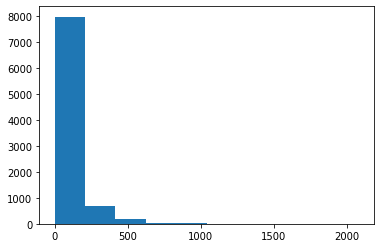

In [95]:
n_reviews_data = []
m_words_data = []


for u, values in user_dict.items():
    n_reviews_data.append(values['n_reviews'])
    m_words_data.append(values['m_words'])
    
#plt.hist(n_reviews_data)
plt.hist(m_words_data)

In [96]:
# TODO: plot distributions in with meaningful bin sizes/intervals, e.g. 1-2, 3-4, 5-7, >8

Mean: 100.0
Median: 80.7


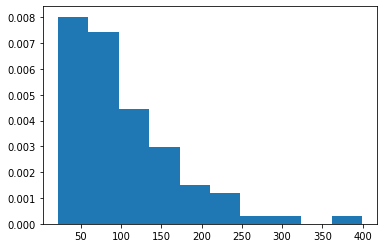

In [109]:
n_reviews_data = []
m_words_data = []


for u, values in item_dict.items():
    n_reviews_data.append(values['n_reviews'])
    m_words_data.append(values['m_words'])
    
#plt.hist(n_reviews_data)
plt.hist(m_words_data, density=True)
print("Mean: %.1f" % np.mean(m_words_data))
print("Median: %.1f" %np.median(m_words_data))

## Bert Stuff

In [166]:
#bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
print(bert_tokenizer.convert_tokens_to_ids(bert_tokenizer.tokenize("Let's see all hidden-states and attentions on this text")))
#print(bert_tokenizer.convert_tokens_to_ids(bert_tokenizer.tokenize("Let's see all hidden-states? and attentions on this text")))

[2292, 1005, 1055, 2156, 2035, 5023, 1011, 2163, 1998, 3086, 2015, 2006, 2023, 3793]


In [22]:
word_embeddings = bert_model.get_input_embeddings()

In [23]:
sent = "This is a test-sentence, so let's see what happens"
#tokens = bert_tokenizer.tokenize(sent)
#tokens = ['[CLS]'] + list(tokens) + ['[SEP]']
#tokens = bert_tokenizer.convert_tokens_to_ids(tokens)

tokens = bert_tokenizer.encode(sent, max_length=30, add_special_tokens=True, pad_to_max_length=True)
x = torch.tensor(tokens, requires_grad=False).long()
tokens

[101,
 2023,
 2003,
 1037,
 3231,
 1011,
 6251,
 1010,
 2061,
 2292,
 1005,
 1055,
 2156,
 2054,
 6433,
 102,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [24]:
%%time
if not bert_loaded:
    bert_model = BertModel.from_pretrained('bert-base-uncased', output_hidden_states=True,
                                            output_attentions=True)
    
    bert_model.resize_token_embeddings(len(bert_tokenizer))

CPU times: user 5 µs, sys: 1 µs, total: 6 µs
Wall time: 8.58 µs


In [25]:
x_in = torch.stack([x, x], dim=0)
x_in.shape

torch.Size([2, 30])

In [26]:
outputs = bert_model(x_in)

In [27]:
len(outputs)
#last hidden state
outputs[0].shape #batchsize x seq_length x hidden_units

torch.Size([2, 30, 768])

In [28]:
outputs[1].shape #pooled output

torch.Size([2, 768])

From the documentation: 
"This output is usually NOT a good summary of the semantic content of the input, 
you’re often better with averaging or pooling the sequence of hidden-states for the whole input sequence."

In [29]:
len(outputs[2]) #hidden_states at each output layer

13

In [30]:
len(outputs[3]) #attentions

12

## Playground

In [31]:
tokens_embedded = word_embeddings(x)
tokens_embedded.shape

torch.Size([30, 768])

In [32]:
last_hidden = outputs[0][0,:,:].squeeze()
last_hidden.shape

torch.Size([30, 768])

In [33]:
torch.equal(last_hidden, tokens_embedded)

False

In [34]:
last_hidden = last_hidden.view(1, last_hidden.shape[0], last_hidden.shape[1])
last_hidden.shape

torch.Size([1, 30, 768])

In [35]:
def output_size(l_in, pad, kernel, stride):
    l_out = l_in + 2*pad - kernel
    l_out /= stride
    l_out += 1
    return l_out

In [36]:
x = torch.sum(last_hidden, dim=1)
x.shape

torch.Size([1, 768])

In [37]:
x2 = torch.mean(last_hidden, dim=1)
x2.shape

torch.Size([1, 768])

In [51]:
text = {}

In [52]:

#text[0:10] = torch.zeros([10,10])
keys = range(0,11)
values = torch.zeros([len(keys), 10, 10])
text = {**text, **dict(zip(keys, values))}
text.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

In [54]:
keys = range(10,21)
values = torch.zeros([len(keys), 10, 10])
text = {**text, **dict(zip(keys, values))}

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [137]:
print(last_hidden.permute(0,2,1).size())

torch.Size([1, 768, 30])


In [142]:
avg_pool = torch.nn.AvgPool1d(2, stride=3)

avg_pool(last_hidden.permute(0,2,1)).shape

torch.Size([1, 768, 10])

In [139]:
torch.zeros(tokens_embedded.shape)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

Options for Encoding Sentences: 
1. Bert Embeddings (Raw): tokenise text and apply Bert Embeddings, no further processing [batch_size x seq_len x dim_e] => subsequent (sophisticated) Encoder should produce sentence representation [batch_size x dim_s]
2. Last Hidden States: sequence encoded by Bert, powerful processing [batch_size x seq_len x dim_e] => subsequent (simple) Encoder produce sentence representation [batch_size x dim_s]
3. Average over Last Hidden States: seq. encoded by Bert and average in the end to yield sentence representation [batch_size x dim_s]

In [217]:
list(df['reviewText'])[0]

"A story children will love and learn from The King, the Mice and the Cheese by Nancy Gurney is an excellent children's book.  It is one that I well remember from my own childhood and purchased for my daughter who loves it.\n\nIt is about a king who has trouble with rude mice eating his cheese. He consults his wise men and they suggest cats to chase away the mice. The cats become a nuisance, so the wise men recommend the king bring in dogs to chase the cats away.  The cycle goes on until the mice are finally brought back to chase away the elephants, brought in to chase away the lions that'd chased away the dogs.\n\nThe story ends in compromise and friendship between the mice and the king.  The story also teaches cause and effect relationships.\n\nThe pictures that accompany the story are humorous and memorable.  I was thrilled to discover that it is back in print.  I *highly* recommend it for children ages 2 to 7."

In [39]:
%%time
max_elems=2
encoded_in = [bert_tokenizer.encode(sent, max_length=30, add_special_tokens=True, pad_to_max_length=True) for sent in list(df['reviewText'])[:3]] 

CPU times: user 15.4 ms, sys: 0 ns, total: 15.4 ms
Wall time: 18.6 ms


In [40]:
len(encoded_in)

3

In [41]:
x_in = torch.tensor(encoded_in, requires_grad=False).long()

In [42]:
outputs = bert_model(x_in)[:2]